# Generate stock prices using Geometric Brownian Motion

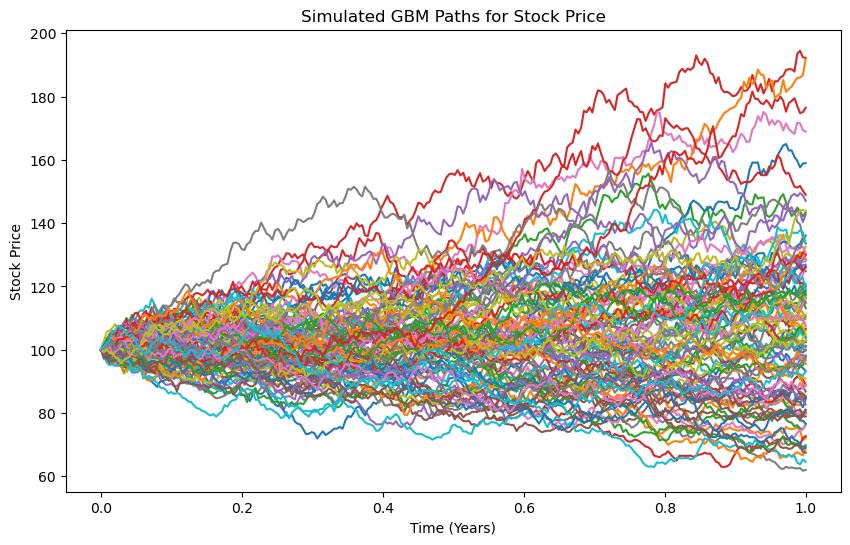

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
mu = 0.05  # expected return
sigma = 0.2  # volatility
S0 = 100  # initial stock price
T = 1.0  # total time (in years)
dt = 1/252  # time step in years
N = int(T / dt)  # number of time steps

# Time grid
t = np.linspace(0, T, N)
# Number of simulations
M = 100  # number of simulated paths

# Simulating M stock price paths
S = np.zeros((M, N))
S[:, 0] = S0

np.random.seed(1)  # For reproducibility

for i in range(1, N):
    z = np.random.standard_normal(M)  # draws from standard normal distribution
    S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

# Plotting the first few paths
plt.figure(figsize=(10, 6))
plt.plot(t, S.T)
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('Simulated GBM Paths for Stock Price')
plt.show()

# Use Long Short-Term Memory (LSTM) model to learn the data

LSTM is a type of RNN that provides a short-term memory that can last thousands of timesteps

The data we need to feed in LSTM is processed using sliding window:

It loops over the series and for each each position of the window, 
- slices a chunk of data of size `n_steps` to serve as an input/feature (`seq_x`).
- The value immediately following the end of this input sequence is considered as the corresponding output (`seq_y`).

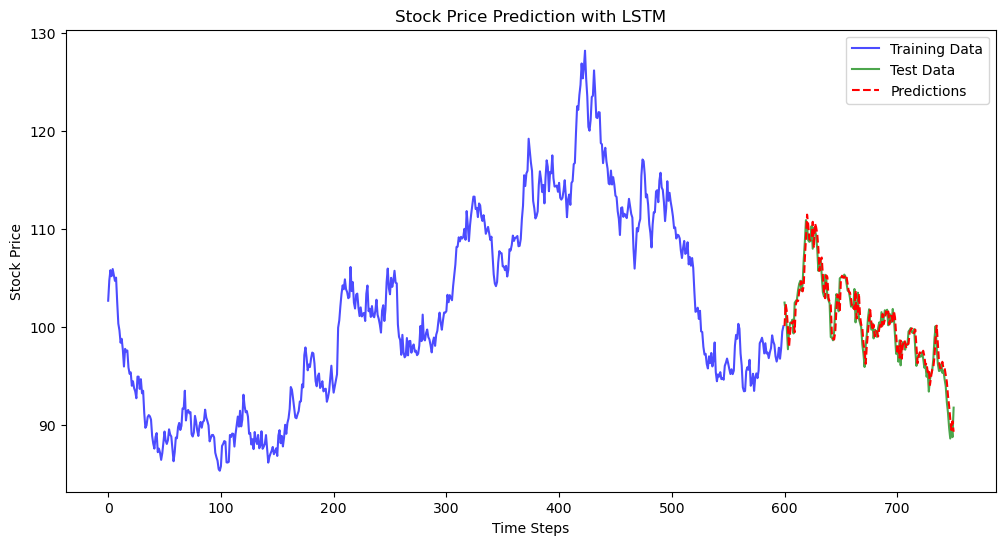

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# this is to prevent a unuseful logging
# see https://github.com/tensorflow/tensorflow/issues/59779

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# GBM parameters
np.random.seed(42)  # For reproducibility
T = 3.0  # Time horizon (1 year)
mu = 0.05  # Drift
sigma = 0.2  # Volatility
S0 = 100  # Initial stock price
dt = 1/252  # Time increment, assuming 252 trading days in a year
N = int(T / dt)  # Number of time steps

# simulate one path of stock price
t = np.linspace(0, T, N)
W = np.random.standard_normal(size=N)
W = np.cumsum(W)*np.sqrt(dt)  # Standard Brownian motion
X = (mu-0.5*sigma**2)*t + sigma*W
S = S0*np.exp(X)  # GBM formula

# Preparing data for LSTM model
def prepare_data(series, n_steps):
    # Initialize empty lists to hold the subsequences (X) and the next value to predict (y)
    X, y = [], []
    
    # Iterate over the series with a sliding window of size n_steps
    for i in range(len(series)):
        # Define the end of the current window
        end_ix = i + n_steps
        if end_ix > len(series)-1:
            break  # if we are beyond the end of the series, exit the loop
        
        # Retrieve the window of observations (subsequence) and the value to predict
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


n_steps = 5
X, y = prepare_data(S, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Splitting the dataset
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Define the optimizer with a specific learning rate
learning_rate = 0.005
optimizer = Adam(learning_rate=learning_rate)

# Defining the LSTM model
model = Sequential() # A Sequential model in Keras is a linear stack of layers. 
# add a LSTM layer of 50 node
model.add(LSTM(50, activation='tanh', input_shape=(n_steps, 1))) 
# add a dense layer with one node since we are predict a single value at each time step
model.add(Dense(1))

model.compile(optimizer=optimizer, loss='mse')

# Training the model
model.fit(X_train, y_train, epochs=1000, verbose=0)

# Making predictions
y_pred = model.predict(X_test, verbose=0)

# Prepare predictions for plotting
full_series = np.concatenate((y_train, y_test), axis=0)
# Generate a NaN array of the same shape as full_series
predictions_full = np.empty_like(full_series)
predictions_full[:] = np.nan
predictions_full[len(y_train):len(full_series)] = y_pred.flatten()

# Generate the time steps for plotting
time_steps = np.arange(len(full_series))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps[:len(y_train)], y_train, label='Training Data', color='blue', alpha=0.7)
plt.plot(time_steps[len(y_train):], y_test, label='Test Data', color='green', alpha=0.7)
plt.plot(time_steps, predictions_full, label='Predictions', color='red', linestyle='--')

plt.title('Stock Price Prediction with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()